# Deep Convolutional Generative Adversarial Network (DCGAN) for Bored Apes

Would you buy a piece of digital art, a 631 x 631 pixels image, for \$200,000? This is actually the least money you can pay to purchase an NFT from the Bored Ape Yach Club collection (you can think of NFTs as a way to ensure uniqueness and ownership of digital art). It contains 10,000 digital images of cartoon apes. The project was launhed in April 2021 and has been one of the most successful NFT projects.

In this notebook, we use Deep Convolutional Generative Adversarial Networks (DCGAN) to generate new Bored Ape Yacht Club NFTs. Generative Adversarial Network, in general, is a Deep Learning Architecture wherein two agents, a Generator and Discriminator, compete against each other. The Generator attempts to create fake images that look like the real ones. The Discriminator's job is to discern between the real and fake images. Based on the Discriminator's feedback, the Generator attempts to improve. The training goes for many epochs. Ideally, until the Discriminator cannot tell the difference between the real and fake images. The process can be visualized as follows:

[ADD AN IMAGE]

In the sections below, we will dive into the process in more detail. The structure of the Notebook is following:
1. Preparing Data
2. Creating the Generator & Discriminator models
3. Defining the Loss & Optimization function
4. Describing the traning models
5. Evaluating results and images
6. Final Discussion

We also want to acknowledge that we reuse some code from Tensorflow's GAN Notebook, which you can find [here](https://www.tensorflow.org/tutorials/generative/dcgan).



### Import Libraries

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/tensorflow/docs to c:\users\nikita\appdata\local\temp\pip-req-build-ai230u4v


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\Nikita\AppData\Local\Temp\pip-req-build-ai230u4v'
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pickle

from IPython import display

### Dataset

We downloaded the Bored Apes NFT dataset from [this Kaggle Dataset](https://www.kaggle.com/stanleyjzheng/bored-apes-yacht-club/version/2). One of the images were corrupt, so we manually removed it, leaving us with 9999 Bored Apes.

We processed the images by converting them from BRGA to RGBA image format, resizing them to 64x64, and saving them in a pickle file from which we can quickly reload the data. 

While we would love to generate 631x631 pixel size fake Bored Apes, our computational availability wouldn't allow that. Hence, we settled on 64x64 size which would speed up our training.

In [14]:
# run this only if the Pickle file isn't already created
import cv2

depth = 4
image_size_y = 64
image_size_x = 64

image_data = []

# for each image in the folder:
for image in glob.glob('test_dataset/*.jpg'):
    # read the image
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    
    # convert it from BGRA to RGBA for matplolib compatibility
    # https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_matplotlib_rgb_brg_image_load_display_save.php
    b,g,r,a = cv2.split(img)       # get b,g,r,a
    img = cv2.merge([r,g,b,a])     # switch it to rgba

    # resize to 64x64
    img = cv2.resize(img, dsize=(image_size_y, image_size_x), interpolation=cv2.INTER_AREA)
    image_data.append(img)

# dump the data into a pickle file
#with open('bored_apes_64_4.pkl', 'wb') as file:
    #dataset = image_data
    #pickle.dump(dataset, file)
image_data = np.array(image_data)   

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file = open('bored_apes_64_4.pkl', 'rb')
image_data = pickle.load(file)
file.close()

In [15]:
# Define some constants
depth = 4
image_size_y = 64
image_size_x = 64
BUFFER_SIZE = 9999
BATCH_SIZE = 256

# reshape the dataset to (9999, 64, 64, 4)
train_images = image_data.reshape(len(image_data), image_size_x, image_size_y, depth).astype('float32')
# rescale the pixel values to [-1, 1]
train_images = (train_images - 127.5) / 127.5 
# convert to valid tensorflow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

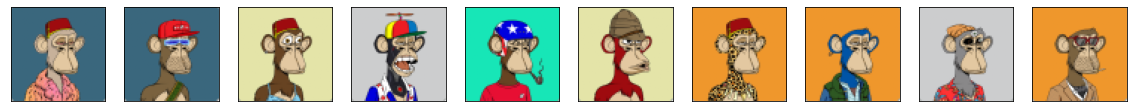

In [16]:
def plot_images(n, images):
    '''
    Plots n images from the dataset
    '''
    # turn the images from [-1, 1] to [0, 1]
    images = images*127.5 + 127.5
    images = images / 255.0

    plt.figure(figsize=(20, 10))
    
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
    plt.show()
    
plot_images(10, train_images)

Finally, after the image processing, our Bored Apes to 'excited' to stand in-between the Generator vs. Discriminator battle.

## Model Architecture

In this section, we will describe in-detail the architectures of Generator and Discriminator.

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

As mentioned above, the Generator's job is to create fake images that look like the real ones. It takes an array of random noise as input and then, using Convolutional and Upsampling layers, it creates an image. In particular, we use tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image of a desired size from a random noise. It takes a few layers to scale up to the desired size. 

- Explain BatchNormalization
- Explain Leaky Relu
- Explain use_bias=False
- Explain strides=(5, 5)



In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8,512)))
    assert model.output_shape == (None, 8, 8, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 4)

    return model

Let's create an image with the yet untrained generator. As expected, it doesn't generate anything but random noise. But sit tight, as Generator's time is yet to come!

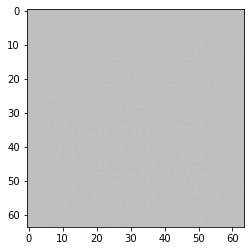

In [18]:
generator = make_generator_model()

# generator random noise
noise = tf.random.normal([1, 100])

# generate an image and set training to False to ensure no training happens in the process
generated_image = generator(noise, training=False)

# convert the pixel values from [-1, 1] to [0, 1] for matplotlib compatibility.
plt.imshow((generated_image[0, :, :, :]*127.5 + 127.5) / 255.0)

### The Discriminator

The discriminator is a CNN-based image classifier.

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same',
                                     input_shape=[64, 64, 4]))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Dropout(0.05))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [21]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 256)       9472      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 256)      

In [22]:
from tensorflow.keras.applications import VGG16

def make_discriminator_model():
    #extract features from pretrained model mobile-net
    model = VGG16(weights='imagenet',
                            include_top=False, input_shape=(64, 64, 4))
    model.trainable = False
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

ValueError: The input must have 3 channels; got `input_shape=(64, 64, 4)`

## Loss functions and optimizers

Define loss functions and optimizers for both models.


In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In this section, we will go in more details on the training process.

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.0)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [83]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [2]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [4]:
display_image(EPOCHS)

NameError: ignored

Use `imageio` to create an animated gif using the images saved during training.

In [10]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

NameError: ignored

In [9]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

NameError: ignored

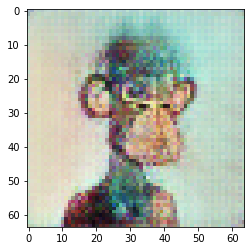

In [72]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :]*127.5 + 127.5) / 255.0)

## Evaluation

In this section, we will evaluate the GAN's performance via quantitative and qualitative methods.

## Discussion


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
